# NLP II. - Transformer Basics
## Sequence-to-Sequence

Sometimes we want to process sequential data: the elements of the sequence has temporal information, that is the order of the input matters. 4 types of sequence-to-sequence modelling:

* One to many: A single input produces a sequence of outputs
  * e.g. image captioning
* Many to one: A sequence of inputs produces a single output.
  * e.g. sentiment analysis
* Many to many aligned: A sequence of inputs produces a sequence of outputs of the same length.
  * e.g. video frame classification
* Many to many unaligned: a sequence of inputs produces a sequence of outputs, where the input and output lengths can differ.
  * e.g. translation

<img src="../img/02_transformer_basics/seq2seq.png" width="800">

[source](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)

## Transformer

The Transformer is a Deeplearning model architecture from 2017, originally designed for language translation. It consists of two parts:
* The Encoder
  * inputs the tokenized source language text and
  * produces a vector representation of the whole input text (it can be considered as a text embedding, notice that so far we only considered the embedding of words separately, not whole texts).
* The Decoder
  * inputs the embedding of the input text and the tokenized first few words of the translated sentence and
  * outputs a probability distribution over the target language vocabulary to predict the next word (token) of the translated sentence.
    * It means that it is an auto-regressive model, that is to generate the whole sentence we have to feed the previous output and use it to generate the next word. The generation stops when we reach a maximum length or the generated token is the \<EOS\> flag (End Of Sentence). To start the generation we first feed the \<SOS\> (Start Of Sentence) special token, so we don't have to guess the first word of the sentence. In the tokenized training data we also add a \<SOS\> and an \<EOS\> token to the start and the end of each sentence.

<img src="../img/02_transformer_basics/transformer_architecture.png" width="400">



### Projection and Softmax

We use a linear layer at the end to transform the output of the previous hidden layer (we call this the dimension of the transformer model) to the dimension of the vocabulary, we call these the `logits`. Then we use the Softmax function to convert the logits to a probability distribution.

$\frac{e^{1.3}}{e^{1.3} + e^{5.1} + e^{2.2} + e^{0.7} + e^{1.1}} \approx 0.02 $

<img src="../img/02_transformer_basics/softmax.png" height="300">
<img src="../img/02_transformer_basics/exp.png" height="300">


In [2]:
import torch

def softmax(logits: torch.Tensor) -> torch.Tensor:
    norm = (torch.exp(logits)).sum(dim=1)
    norm = norm.unsqueeze(dim=1)

    probabilities = torch.exp(logits) / norm

    return torch.round(probabilities, decimals=2)

In [ ]:
logits = torch.tensor([[1.3, 5.1, 2.2, 0.7, 1.1]])
softmax(logits)

tensor([[0.0200, 0.9000, 0.0500, 0.0100, 0.0200]])

### Matrix Multiplication

<img src="../img/02_transformer_basics/matrix_mul.png" height="300">



### Embeddings

The first component of the model is the embedding layer to encode the tokens. During the training it will learn it's own embeddings for each token, we don't use pre-trained embeddings (that's why the input is simply the embedding tokens).

In [3]:
import torch

vocab_size = 5
embedding_dim = 3
embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

embeddings.weight.detach()

tensor([[ 0.8952, -0.4526, -0.4170],
        [-0.7879,  0.3964, -0.0376],
        [ 0.6600,  0.1145,  0.6525],
        [-1.6944, -0.2856, -0.3750],
        [ 1.3124, -1.2431, -0.1680]])

In [4]:
token_ids = torch.tensor([0, 1, 4, 2])
embeddings(token_ids).detach()

tensor([[ 0.8952, -0.4526, -0.4170],
        [-0.7879,  0.3964, -0.0376],
        [ 1.3124, -1.2431, -0.1680],
        [ 0.6600,  0.1145,  0.6525]])

In [5]:
token_ids = torch.tensor([0, 1, 4, 2])
embeddings(token_ids).detach().T

tensor([[ 0.8952, -0.7879,  1.3124,  0.6600],
        [-0.4526,  0.3964, -1.2431,  0.1145],
        [-0.4170, -0.0376, -0.1680,  0.6525]])

### Scaled Dot-Product Attention

$\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$

Intuition:

<img src="../img/02_transformer_basics/attention_intuition.png" width="600">

Our goal is to modify the embeddings using the context. Instead of having the simple embedding of a `cat` we know that it is "the black cat" and we want to have an embedding that encodes all this information denoted by `cat'` on the image.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_similarities(similarities, labels, title=None):
    # Plot matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(similarities, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels)
    if title is not None:
        plt.title(title)
    plt.show()

In [7]:
# Load 3 million Word2Vec Vectors, pre-trained on Google news, each with the dimension of 300
# This model may take a few minutes to load.

import gensim.downloader as api
import time

start_time = time.time()
w2v_google = api.load("word2vec-google-news-300")
print("--- %s seconds ---" % (time.time() - start_time))

--- 30.193218231201172 seconds ---


In [9]:
import torch

words = ["the", "cat", "is", "black"]
N = len(words)

QUERIES = torch.tensor([w2v_google[word] for word in words])  # (N, 300)
KEYS = torch.tensor([w2v_google[word] for word in words])     # (N, 300)
VALUES = torch.tensor([w2v_google[word] for word in words])   # (N, 300)

QUERIES.size()

torch.Size([4, 300])


First we try to find out which are the relevant other words from the context for each word by calculating the dot-products for each pair.

<img src="../img/02_transformer_basics/similarity.png" width="400">

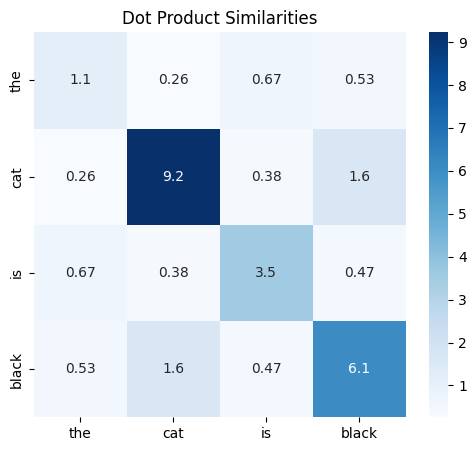

In [10]:
# similarities = QUERIES @ KEYS.T

similarities = torch.zeros(size=(N, N))

for i, query in enumerate(QUERIES):
    for j, key in enumerate(KEYS):
        prod = query*key
        dot_prod = prod.sum()

        similarities[i,j] = dot_prod

plot_similarities(similarities, words, title="Dot Product Similarities")

In [11]:
print(similarities.std(dim=1))

scaled_similarities = similarities / (300**0.5)
print(scaled_similarities.std(dim=1))

tensor([0.3731, 4.2803, 1.5227, 2.6436])
tensor([0.0215, 0.2471, 0.0879, 0.1526])


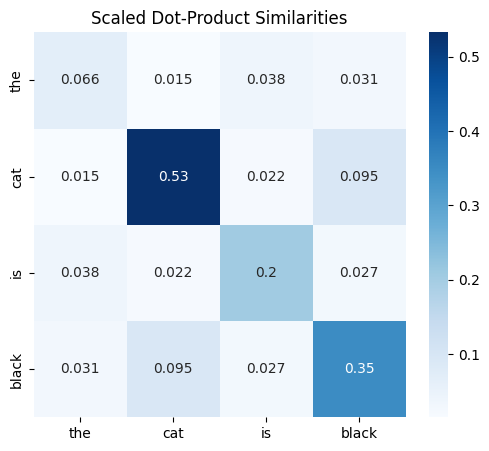

In [12]:
plot_similarities(scaled_similarities, words, title="Scaled Dot-Product Similarities")

Now we turn the similarities into weights in a way that more similar pairs have higher weights, for this we apply the Softmax function on each row.

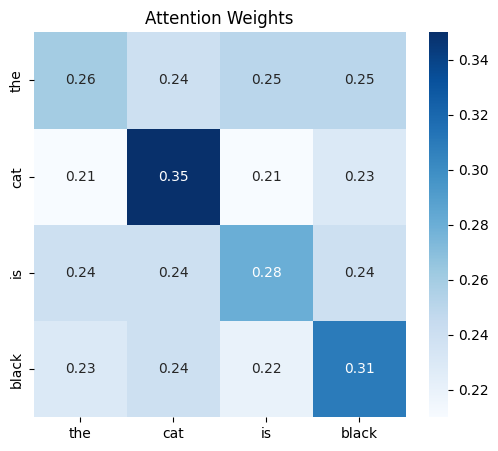

In [13]:
weights = softmax(scaled_similarities)
plot_similarities(weights, words, title="Attention Weights")

Now, it's time to use the weights to form the new embeddings: each new embedding is the weighted sum of all the embeddings:

`the' = w_1 * the + w_2 * cat + w_3 * is + w_4 * black`

<img src="../img/02_transformer_basics/values.png" width="600">

In [ ]:
# output = weights @ VALUES

output = torch.zeros(size=(N, 300))

for i, weight in enumerate(weights):
    weighted_sum = (weight.unsqueeze(dim=1) * VALUES).sum(dim=0)
    output[i] = weighted_sum

output.size()

torch.Size([4, 300])

### Self-Attention

The Key, Query and Value vectors are coming from the same embeddings and we transform them with different Linear Layers.

In [ ]:
words = ["the", "quick", "brown", "fox", "jumps", "over", "lazy", "dog"]
embeddings = torch.tensor([w2v_google[word] for word in words])

embeddings.size()

torch.Size([8, 300])

In [ ]:
K = torch.nn.Linear(300, 300)
Q = torch.nn.Linear(300, 300)
V = torch.nn.Linear(300, 300)

In [ ]:
def SelfAttention(K, Q, V, embeddings):
    key = K(embeddings)
    query = Q(embeddings)
    value = V(embeddings)

    batch_size, d_k = key.size()

    scaled_similarities = (query @ key.T) / (d_k**0.5)
    weights = softmax(scaled_similarities)

    return weights @ value

output = SelfAttention(K, Q, V, embeddings)
output.size()

torch.Size([8, 300])

This way we can transform the embeddings using the surrounding embeddings.

### Cross-Attention

The Cross-Attention is a bridge, connecting the encoder and the decoder. The encoder summarizes the input and the decoder uses that information to produce the final output.

In this process:
- The **keys** and **values** are the encoder's output, which hold all the important details about the input.
- The **query** is from the decoder's previous layer, asking: "What part of the whole sequence should I pay attention to right now?"

In other words, it helps the decoder to decide which parts of the encoder's output are most relevant for generating the next word in the sequence.


### Multi-Head Attention

Instead of using a single attention mechanism, the model applies multiple attention heads in parallel. Each head performs independent qurey, key and value projections with learned weights. The outputs from all heads are concatenated and then projected again.

Splitting attention into multiple heads allows the model to focus on different aspects of the input.


In [ ]:
import torch

# Example: Multi-Head Attention
class MultiHeadAttentionExample(torch.nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttentionExample, self).__init__()
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert (
            self.head_dim * num_heads == embed_size
        ), "Embedding size must be divisible by the number of heads"

        self.query = torch.nn.Linear(embed_size, embed_size)
        self.key = torch.nn.Linear(embed_size, embed_size)
        self.value = torch.nn.Linear(embed_size, embed_size)

        # Final linear layer after concatenating heads
        self.fc_out = torch.nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, queries):
        batch_size = queries.size()[0]
        query_len, key_len, value_len = queries.size()[1], keys.size()[1], values.size()[1]

        queries = self.query(queries)  # (batch_size, query_len, embed_size)
        keys = self.key(keys)          # (batch_size, key_len, embed_size)
        values = self.value(values)    # (batch_size, value_len, embed_size)

        # Split embeddings for each head
        queries = queries.view(batch_size, query_len, self.num_heads, self.head_dim)
        keys = keys.view(batch_size, key_len, self.num_heads, self.head_dim)
        values = values.view(batch_size, value_len, self.num_heads, self.head_dim)

        # Scaled Dot-Product Attention
        queries = queries.transpose(1, 2)  # (batch_size, num_heads, query_len, head_dim)
        keys = keys.transpose(1, 2)        # (batch_size, num_heads, key_len, head_dim)
        values = values.transpose(1, 2)    # (batch_size, num_heads, value_len, head_dim)

        similarities = torch.matmul(queries, keys.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attention_weights = torch.softmax(similarities, dim=-1)  # (batch_size, num_heads, query_len, key_len)

        out = torch.matmul(attention_weights, values)  # (batch_size, num_heads, query_len, head_dim)

        # Concatenate heads
        out = out.transpose(1, 2).contiguous()  # (batch_size, query_len, num_heads, head_dim)
        out = out.view(batch_size, query_len, -1)  # (batch_size, query_len, embed_size)

        out = self.fc_out(out)  # (batch_size, query_len, embed_size)
        return out


In [ ]:
embed_size = 8
num_heads = 2
multi_head_attention = MultiHeadAttentionExample(embed_size, num_heads)

# Random input
batch_size, seq_len = 1, 3
values = torch.rand(batch_size, seq_len, embed_size)
keys = torch.rand(batch_size, seq_len, embed_size)
queries = torch.rand(batch_size, seq_len, embed_size)

output = multi_head_attention(values, keys, queries)
output.size()

torch.Size([1, 3, 8])

### Positional Encoding

We want to use the order of the words in the sequence, because it matters whether "The dog chased the cat." or "The cat chased the dog.". We use the following formula to encode the positions:

$\text{PE}_{(pos,2i)} = \sin{(pos/10000^{2i/d_{\text{model}}​})}$

$\text{PE}_{(pos,2i+1)} = \cos{(pos/10000^{2i/d_{\text{model}}})}$

where
* $pos$ = token position
* $i$ = embedding dimension index
* $d_{model}$ = embedding size


In [ ]:
from math import sin, cos

pos_encoding = torch.zeros_like(embeddings)
seq_len, d_model = pos_encoding.size()

for pos, embedding in enumerate(embeddings):
    for i, dim in enumerate(embedding):
        if i % 2 == 0:
            pos_encoding[pos, i] = sin(pos/(10000**(2*i/d_model)))
        else:
            pos_encoding[pos, i] = cos(pos/(10000**(2*i/d_model)))


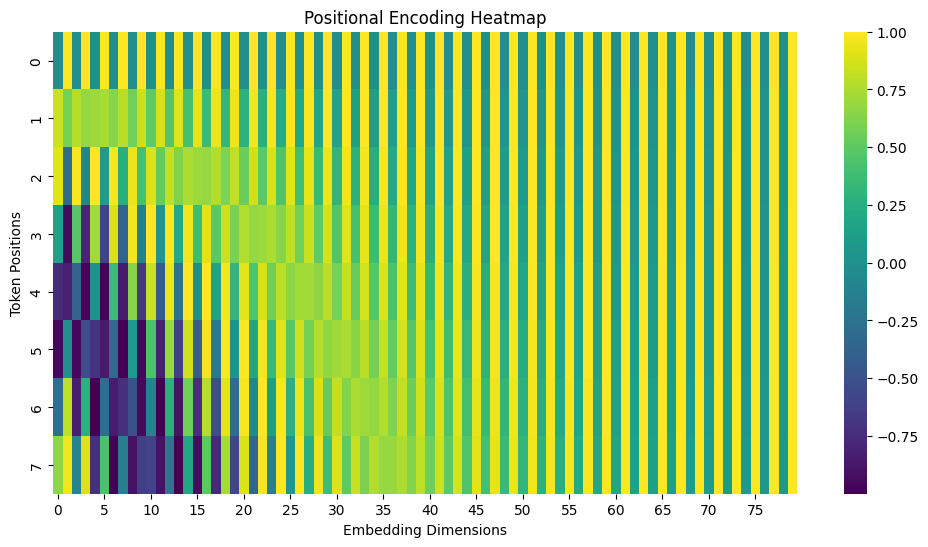

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(pos_encoding[:, :80], cmap="viridis", xticklabels=5, yticklabels=1)
plt.xlabel("Embedding Dimensions")
plt.ylabel("Token Positions")
plt.title("Positional Encoding Heatmap")
plt.show()

## Transformer Example

Trnaslate Hungarian to English. [Source of data processing](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html).

### Data Loading

In [129]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import os

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [127]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 3  # Count SOS, EOS and PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [128]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [129]:
def readLangs(lang1, lang2, path, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    with open(path, encoding='utf-8') as file:
        lines = file.read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [130]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
)

def filterPair(p):
    return len(p[0].split(' ')) <= MAX_LENGTH and \
           len(p[1].split(' ')) <= MAX_LENGTH and \
           p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [131]:
def prepareData(lang1, lang2, path,reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, path, reverse)

    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)

    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)

    return input_lang, output_lang, pairs

# input_lang, output_lang, pairs = prepareData('eng', 'hun', "../data/translation/hun.txt", True)
# print(random.choice(pairs))

In [132]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'hun', "hun.txt", True)

    n = len(pairs)
    input_ids = np.full((n, MAX_LENGTH+2), fill_value=PAD_token, dtype=np.int32)
    target_ids = np.full((n, MAX_LENGTH+2), fill_value=PAD_token, dtype=np.int32)

    inx = np.arange(len(pairs))
    np.random.shuffle(inx)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        inp_ids = [SOS_token] + inp_ids
        tgt_ids = [SOS_token] + tgt_ids
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_input_ids = input_ids[inx[:8000]]
    val_input_ids = input_ids[inx[8000:]]
    train_target_ids = target_ids[inx[:8000]]
    val_target_ids = target_ids[inx[8000:]]

    train_data = TensorDataset(torch.LongTensor(train_input_ids).to(device),
                               torch.LongTensor(train_target_ids).to(device))
    val_data = TensorDataset(torch.LongTensor(val_input_ids).to(device),
                               torch.LongTensor(val_target_ids).to(device))

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    return input_lang, output_lang, train_dataloader, val_dataloader

### Model

In [133]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=15):
        super(PositionalEncoding, self).__init__()

        self.encoding = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(x.device)

In [134]:
class TransformerModel(nn.Module):
    def __init__(self, input_vocab_size, target_vocab_size, d_model=512, nhead=8, num_layers=3, dim_feedforward=2048):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        # Embedding layers
        self.input_embedding = nn.Embedding(input_vocab_size, d_model)
        self.target_embedding = nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
            num_decoder_layers=num_layers, dim_feedforward=dim_feedforward, dropout=0.1
        )

        # Output layer
        self.fc_out = nn.Linear(d_model, target_vocab_size)

    def generate_square_subsequent_mask(self, length):
        mask = torch.triu(torch.ones(length, length) * float('-inf'), diagonal=1)
        return mask

    def forward(self, src, tgt):
        src_mask = None
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(1)).to(src.device)

        src_emb = self.positional_encoding(self.input_embedding(src) * np.sqrt(self.d_model))
        tgt_emb = self.positional_encoding(self.target_embedding(tgt) * np.sqrt(self.d_model))

        output = self.transformer(src_emb.transpose(0, 1), tgt_emb.transpose(0, 1), src_mask=src_mask, tgt_mask=tgt_mask)

        return self.fc_out(output.transpose(0, 1))


### Training

In [135]:
def evaluate(model, val_dataloader, criterion, device='cpu'):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for src, tgt in val_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)

            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()
            pred = output.argmax(2)
            correct += (pred == tgt_output).sum().item()
            total += tgt_output.numel()

    val_loss = total_loss / len(val_dataloader)
    val_acc = correct / total

    # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")
    return val_loss, val_acc

In [136]:
def train(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=10, device="cpu", print_every=100):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]  # Decoder input
            tgt_output = tgt[:, 1:]  # Ground truth

            optimizer.zero_grad()
            output = model(src, tgt_input)

            # Compute loss
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        val_loss, val_acc = evaluate(model, val_dataloader, criterion, device=device)

        val_losses.append(val_loss)
        train_losses.append(total_loss / len(train_dataloader))

        if (epoch+1) % print_every == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_dataloader):.4f} - Val Loss: {val_loss:.4f} - Val Acc: {val_acc:.4f}")

    return train_losses, val_losses

In [137]:
batch_size = 512

input_lang, output_lang, train_dataloader, val_dataloader = get_dataloader(batch_size)

Reading lines...
Read 118890 sentence pairs
Trimmed to 8353 sentence pairs
Counting words...
Counted words:
hun 6114
eng 2698


In [138]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Instantiate the model
model = TransformerModel(
    input_vocab_size=input_lang.n_words,
    target_vocab_size=output_lang.n_words,
    d_model=512,  # Reduce for faster training
    nhead=8,
    num_layers=5,
    dim_feedforward=512  # Reduced for simplicity
).to(device)

# Define optimizer and loss function
padding_id = PAD_token

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss(ignore_index=padding_id)
NUM_EPOCHS = 400

train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs=NUM_EPOCHS, device=device, print_every=10)

Epoch 10/400, Loss: 4.6824 - Val Loss: 4.4613 - Val Acc: 0.2238
Epoch 20/400, Loss: 3.9519 - Val Loss: 3.7902 - Val Acc: 0.2593
Epoch 30/400, Loss: 3.5650 - Val Loss: 3.4620 - Val Acc: 0.2794
Epoch 40/400, Loss: 3.3145 - Val Loss: 3.2631 - Val Acc: 0.2879
Epoch 50/400, Loss: 3.1173 - Val Loss: 3.0996 - Val Acc: 0.3036
Epoch 60/400, Loss: 2.9487 - Val Loss: 2.9740 - Val Acc: 0.3144
Epoch 70/400, Loss: 2.8011 - Val Loss: 2.8702 - Val Acc: 0.3222
Epoch 80/400, Loss: 2.6706 - Val Loss: 2.7918 - Val Acc: 0.3266
Epoch 90/400, Loss: 2.5544 - Val Loss: 2.7134 - Val Acc: 0.3325
Epoch 100/400, Loss: 2.4460 - Val Loss: 2.6516 - Val Acc: 0.3381
Epoch 110/400, Loss: 2.3447 - Val Loss: 2.5941 - Val Acc: 0.3410
Epoch 120/400, Loss: 2.2546 - Val Loss: 2.5449 - Val Acc: 0.3459
Epoch 130/400, Loss: 2.1653 - Val Loss: 2.5067 - Val Acc: 0.3461
Epoch 140/400, Loss: 2.0806 - Val Loss: 2.4709 - Val Acc: 0.3502
Epoch 150/400, Loss: 2.0002 - Val Loss: 2.4346 - Val Acc: 0.3544
Epoch 160/400, Loss: 1.9224 - Val 

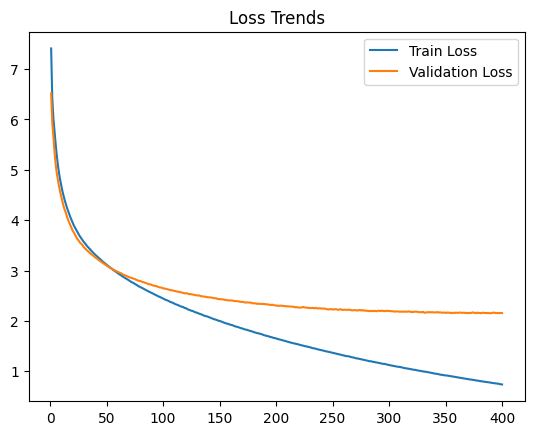

In [139]:
epochs = range(1, NUM_EPOCHS+1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Trends")
plt.show()

### Save and Load Model

In [ ]:
file_path = "trained_transformer_model.pth"

In [142]:
torch.save(model.state_dict(), file_path)

In [150]:
model_loaded = TransformerModel(
    input_vocab_size=input_lang.n_words,
    target_vocab_size=output_lang.n_words,
    d_model=512,  # Reduce for faster training
    nhead=8,
    num_layers=5,
    dim_feedforward=512  # Reduced for simplicity
).to(device)
model_loaded.load_state_dict(torch.load(file_path, weights_only=True))
model_loaded.eval()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


TransformerModel(
  (input_embedding): Embedding(6114, 512)
  (target_embedding): Embedding(2698, 512)
  (positional_encoding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-4): 5 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): T

### Test

In [154]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = [SOS_token] + indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def translate(model, sentence, input_lang, output_lang):
    model.eval()

    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence).to(device)
        tgt_input = torch.tensor([SOS_token], dtype=torch.long).unsqueeze(0).to(device)

        for _ in range(15):
            output = model(input_tensor, tgt_input)
            next_token = output.argmax(2)[:, -1:]
            tgt_input = torch.cat((tgt_input, next_token), dim=1)

            if next_token.item() == EOS_token:
                break

        translated_text = ' '.join(output_lang.index2word[idx.item()] for idx in tgt_input[0, 1:-1])
        return translated_text

print(translate(model_loaded, "itt vagyok", input_lang, output_lang))
print(translate(model_loaded, "itt vagyunk", input_lang, output_lang))
print(translate(model_loaded, "nagy vagy", input_lang, output_lang))
print(translate(model_loaded, "nagyon nagy vagy", input_lang, output_lang))
print(translate(model_loaded, "te nagyon kicsi vagy", input_lang, output_lang))

i m here to be here here
we re here to here here
you re big enough by big
you re very big enough to do that
you re very happy for you ?
